In [1]:
import aacgmv2
import os
import sys
import psycopg2

import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.basemap import Basemap
from itertools import chain
from tqdm import tqdm

import utils
from utils import local_data
from utils import window

%matplotlib inline

In [2]:
df_series_vtec = pd.read_pickle(os.path.join(local_data, "station_data_series_tec.pkl.xz"), compression='xz')
df_series_s4 = pd.read_pickle(os.path.join(local_data, "df_series_s4.pkl.xz"), compression='xz')
df_station = pd.read_pickle(os.path.join(local_data, 'df_station_sort.pkl'))

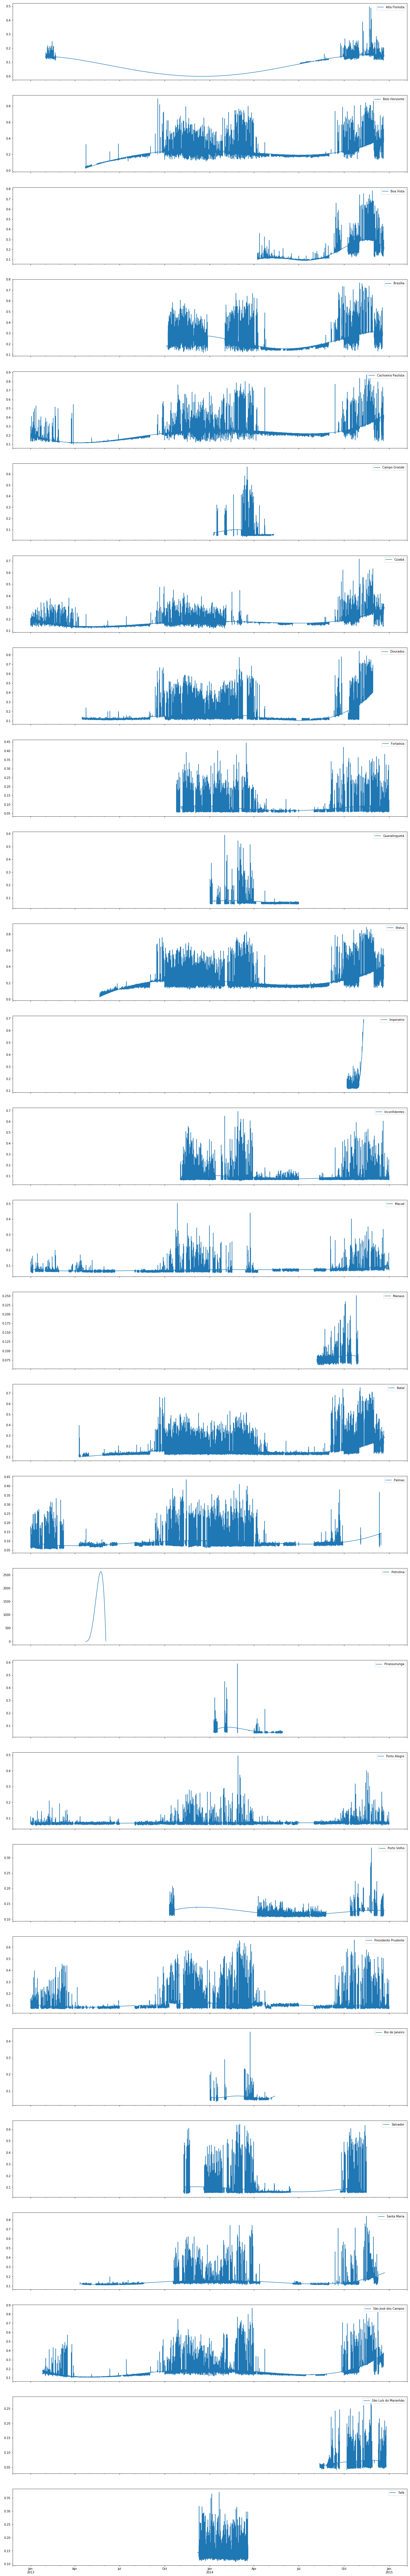

In [3]:
size = df_series_s4.columns.size
fig, ax = plt.subplots(size, 1, sharex=True)
for idx, i in enumerate(df_series_s4.columns):
    name = df_station.loc[df_station['identificationstation'] == i].index[0]
    df_series_s4[i].plot(figsize=(24, 160), ax=ax[idx], label=name)
    ax[idx].legend(loc="upper right")

Analisando os dados os gráficos acima, optou-se por descartar as estações de Petrolina e Imperatriz, cujos idenfiticadores são respectivamentes 'pln' e 'imp'.

In [4]:
remove = ['imp', 'pln']
for i in remove:
    df_station = df_station[df_station.identificationstation != i]
    del df_series_s4[i]
    del df_series_vtec[i]
    

In [5]:
df_station

,identificationstation,alias,height,latitude,longitude,network,state,city,startoperation,stopoperation,city_heigh,city_latitude,city_longitude,mag_latitude,mag_longitude
city_name_correct,,,,,,,,,,,,,,,
Alta Floresta,afl,null,267.000,-9.870000,-55.900000,septentrio,mt,alta floresta,NaN,NaN,264.0,-9.90000,-55.9000,-11.812189,16.212312
Belo Horizonte,bhz,null,858.000,-19.868500,-43.954200,lisn,mg,belo horizonte,NaN,NaN,767.0,-19.81570,-43.9542,-25.426147,24.786619
Boa Vista,bov,null,69.180,2.833920,-60.695380,lisn,rr,boa vista,NaN,NaN,76.0,2.81954,-60.6714,11.622177,14.848847
Brasília,bsa,null,1050.000,-15.764200,-47.869400,lisn,df,brasilia,NaN,NaN,1130.0,-15.78010,-47.9292,-24.348659,22.352744
Cachoeira Paulista,cpa,null,580.000,-22.410000,-45.000000,lisn,sp,cachoeira paulista,NaN,NaN,545.0,-22.67370,-44.9973,-24.456556,22.960540
Campo Grande,32,cg01,NaN,-20.497000,-54.615000,septentrio,ms,campos grande,NaN,NaN,612.0,-20.44350,-54.6478,-21.417704,14.873907
Cuiabá,cub,null,278.000,-15.555200,-56.069800,lisn,mt,cuiaba,NaN,NaN,180.0,-15.59890,-56.0949,-14.336068,14.530440
Dourados,dou,null,756.120,-22.110000,-54.550000,lisn,ms,dourados,NaN,NaN,448.0,-22.22180,-54.8064,-23.627266,14.698554
Fortaleza,24,fort,NaN,-3.742000,-38.539000,septentrio,ce,fortaleza,NaN,NaN,14.0,-3.71839,-38.5434,NaN,NaN


Os dados de S4 englobam dois anos inteiros, o período começando em janeiro de 2013 e terminando em janeiro de 2015. Os dados de vtec por sua vez, restrigem-se a um intervalo menor. Assim, é necessário realizar um corte na série de dados de S4, de forma a ter o mesmo número de analises.

In [6]:
first_date = df_series_vtec.index[0].to_pydatetime()
last_date = df_series_vtec.index[-1].to_pydatetime()
df_series_vtec.shape

(12960, 26)

In [7]:
df_series_s4 = df_series_s4.ix[first_date:last_date]
df_series_s4.shape

/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(12960, 26)

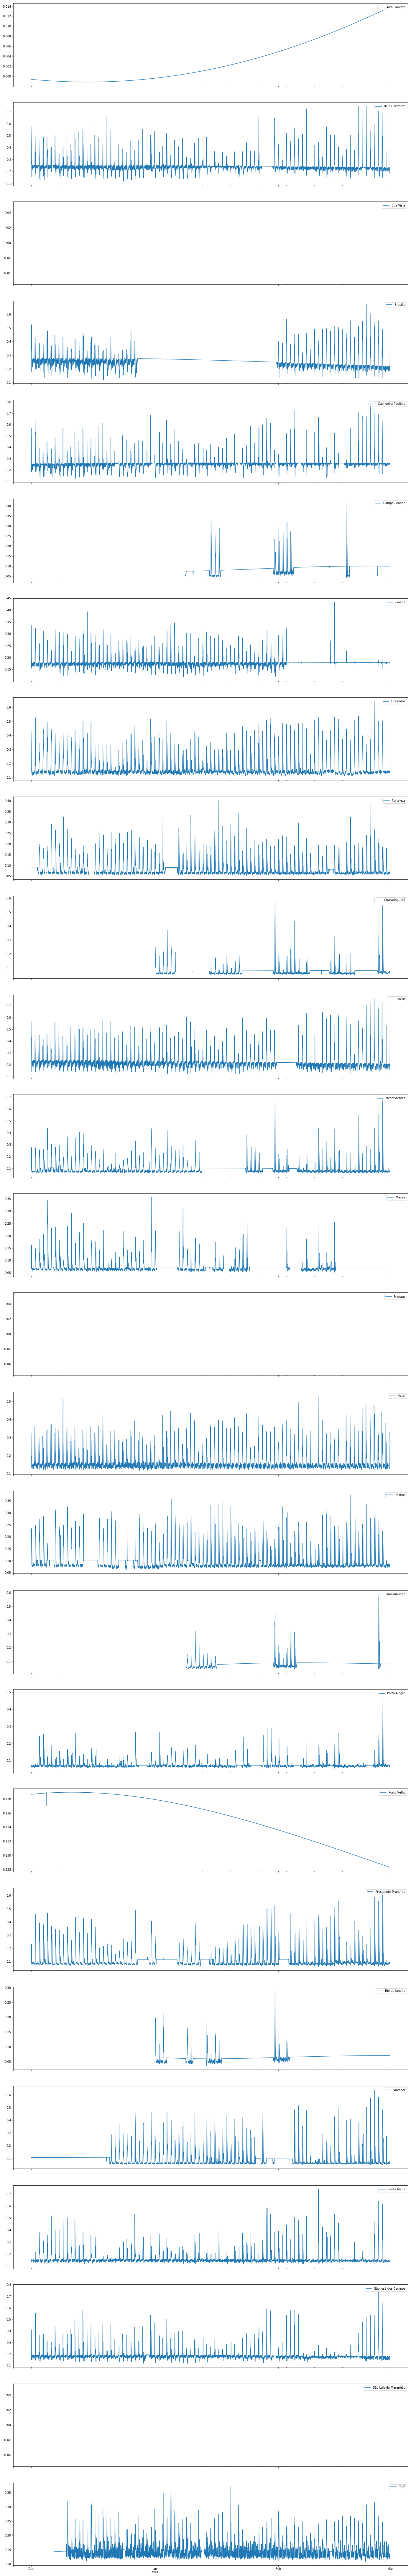

In [8]:
size = df_series_s4.columns.size
fig, ax = plt.subplots(size, 1, sharex=True)
for idx, i in enumerate(df_series_s4.columns):
    name = df_station.loc[df_station['identificationstation'] == i].index[0]
    df_series_s4[i].plot(figsize=(24, 160), ax=ax[idx], label=name)
    ax[idx].legend(loc="upper right")


In [9]:
remove = ['afl', 'bov', '28', 'pvh', '29']
for i in remove:
    df_station = df_station[df_station.identificationstation != i]
    del df_series_s4[i]
    del df_series_vtec[i]

In [10]:
df_series_vtec.to_pickle(os.path.join(local_data, "df_series_tec_re.pkl.xz"), compression='xz')
df_series_s4.to_pickle(os.path.join(local_data, "df_series_s4_re.pkl.xz"), compression='xz')
df_station.to_pickle(os.path.join(local_data, 'df_station_sort_re.pkl'))

In [11]:
mag_lat = df_station['mag_latitude'].values.ravel()
mag_lon = df_station['mag_longitude'].values.ravel()

dtime = dt.datetime(2013, 1, 1)
mag_meridians_lines = []
for lat, lon in zip(mag_lat, mag_lon):
    lats = np.linspace(-90, 90, 720)
    aux_geo_lat = []
    aux_geo_lon = []
    for i in lats:
        geo_lat, geo_lon, _ = aacgmv2.convert_latlon_arr(i, 
                                                         lon, 
                                                         0, 
                                                         dtime=dtime, 
                                                         code="A2G")
        aux_geo_lat.append(float(geo_lat))
        aux_geo_lon.append(float(geo_lon))
        
    mag_meridians_lines.append((aux_geo_lon, aux_geo_lat))

In [12]:
def draw_map(m, scale=0.2):
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 45), labels=[True, True, True, True])
    lons = m.drawmeridians(np.linspace(-180, 180, 90), labels=[True, True, True, True])
    
    # keys contain the plt.line 2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='b')

/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4790: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4791: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4797: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4828: RuntimeWarning: invalid value encountered in less
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4828: RuntimeWarning: invalid value encountered in great

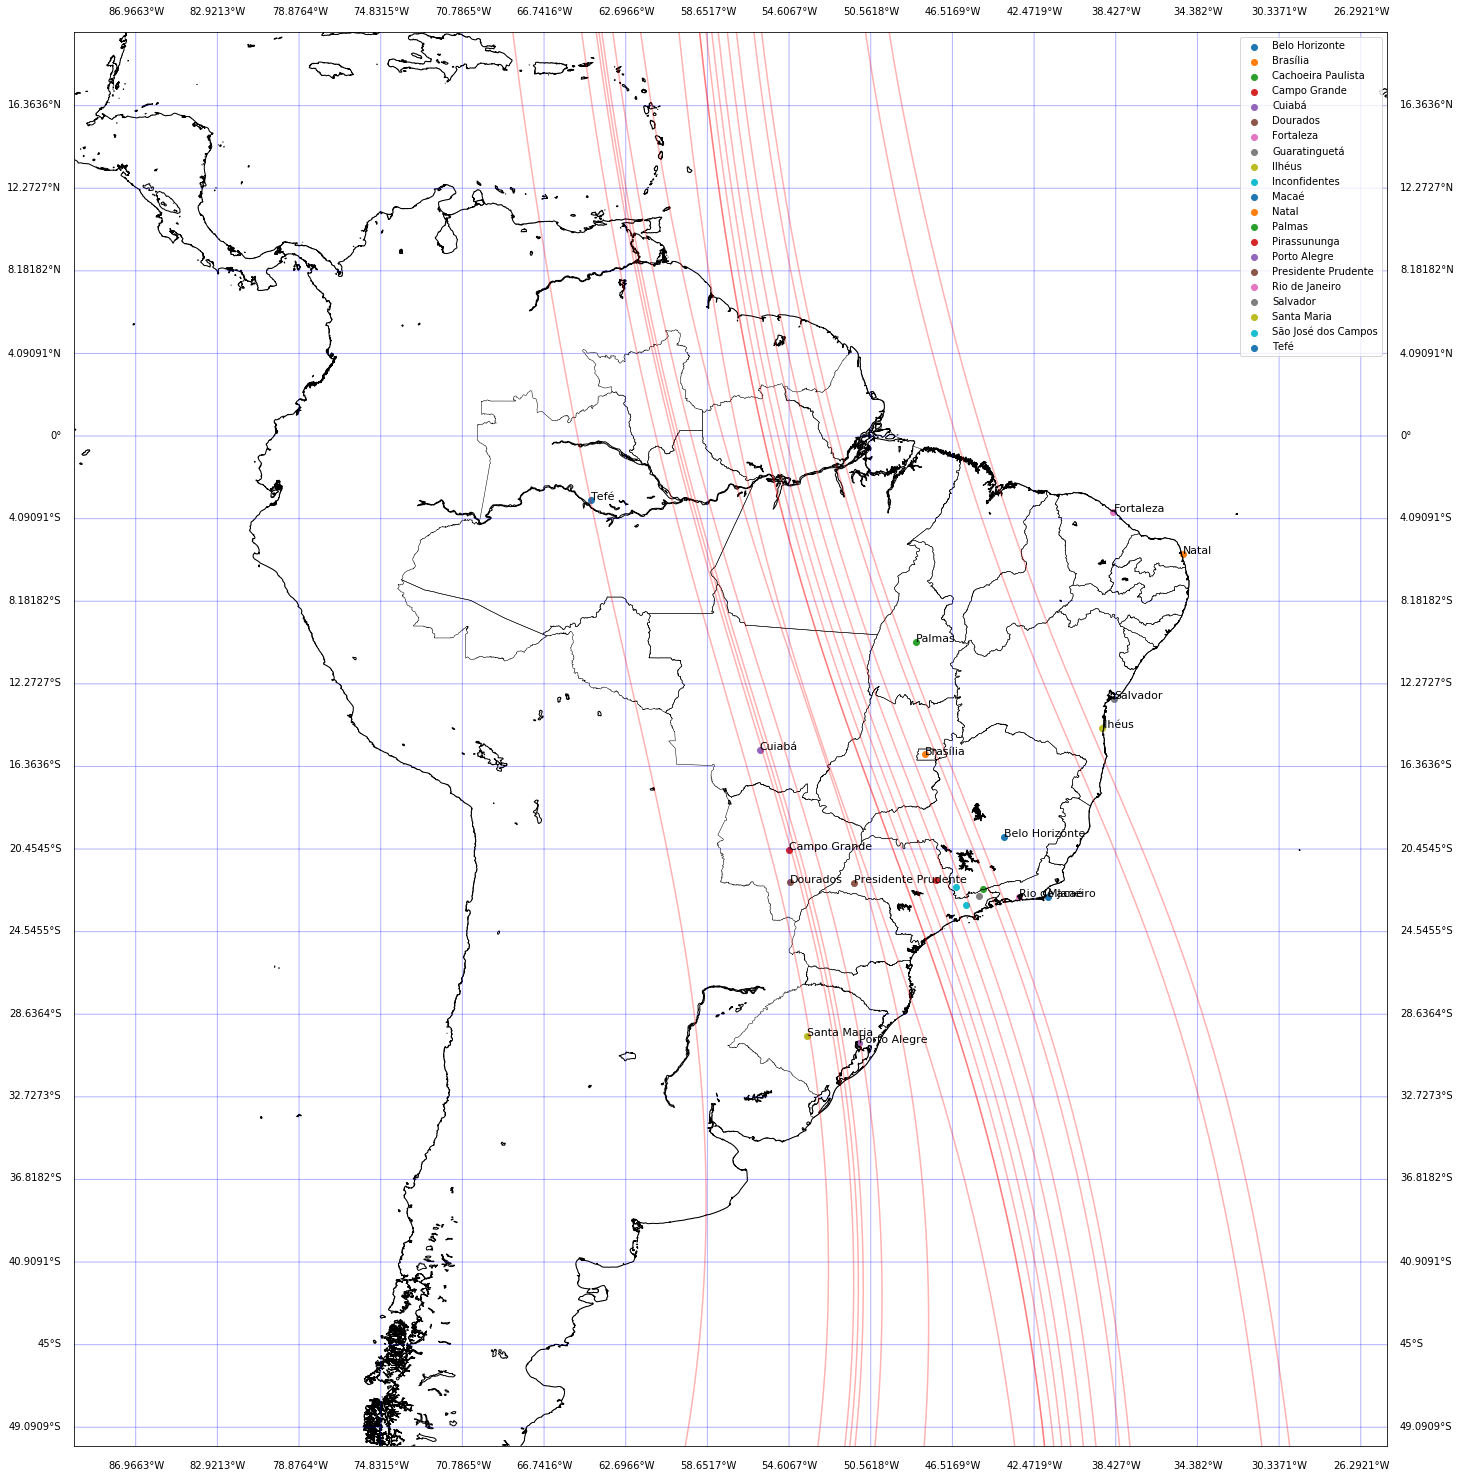

In [13]:
fig = plt.figure(figsize=(26, 26), edgecolor='w')
m = Basemap(projection='cyl',
            resolution='f',
            llcrnrlat=-50,
            urcrnrlat=20,
            llcrnrlon=-90,
            urcrnrlon=-25)
m.drawcoastlines()
m.readshapefile(os.path.join(local_data, 'estados_2010/estados_2010'), 'estados', )
draw_map(m)

for i in mag_meridians_lines:
    m.plot(i[0], i[1], latlon=True, color='r', alpha=0.3)

for i in df_station.itertuples():
    x, y = m(i.longitude, i.latitude)
    m.scatter(x, y, label=i.Index)
    if i.Index not in ['São José dos Campos', 'Cachoeira Paulista', 'Guaratinguetá', 'Inconfidentes', 'Pirassununga']:
        plt.text(x, y, i.Index, fontsize=11)

plt.legend()
plt.savefig('./images/map_stations_re.svg', format='svg', dpi=1000)
plt.show()